In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
import os
path = "/home/paachary/geron/handson-ml2"
FILE_PATH = os.path.join(path, "datasets","housing","housing.csv")
housing = pd.read_csv(FILE_PATH)

In [43]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [44]:
housing['income_cat'] = pd.cut(housing.median_income, bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])

<AxesSubplot:>

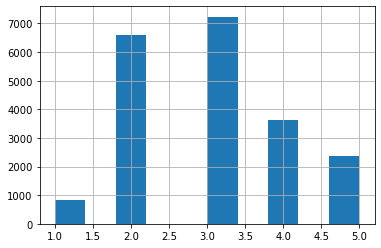

In [45]:
housing.income_cat.hist()

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

In [47]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [48]:
for train_index,test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

<AxesSubplot:>

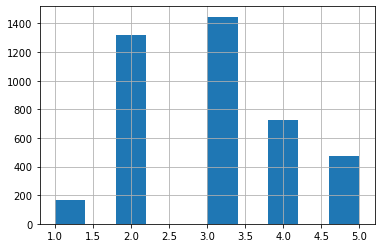

In [49]:
strat_test_set.income_cat.hist()

In [50]:
strat_test_set = strat_test_set.drop("income_cat",axis=1)

In [51]:
strat_train_set = strat_train_set.drop("income_cat",axis=1)

In [52]:
housing = strat_train_set.drop('median_house_value', axis=1)

In [53]:
housing_labels = strat_train_set.median_house_value.copy()

In [54]:
from sklearn.impute import SimpleImputer

In [55]:
imputer = SimpleImputer(strategy="median")

In [56]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [57]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [58]:
X = imputer.transform(housing_num)

In [59]:
housing_cat = housing[['ocean_proximity']]

In [60]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [61]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [62]:
from sklearn.preprocessing import OrdinalEncoder

In [63]:
ordinal_encoder = OrdinalEncoder()

In [64]:
housing_encoded = ordinal_encoder.fit_transform(housing_cat)

In [65]:
housing_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [66]:
from sklearn.preprocessing import OneHotEncoder

In [67]:
cat_encoder = OneHotEncoder()

In [68]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [69]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin

In [71]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

In [72]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedroom_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedroom_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [73]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

In [74]:
housing_extra_attribs = attr_adder.transform(housing.values)

In [75]:
housing.values[3]

array([-119.61, 36.31, 25.0, 1847.0, 371.0, 1460.0, 353.0, 1.8839,
       'INLAND'], dtype=object)

In [76]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [77]:
from sklearn.pipeline import Pipeline

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                        ("attribs_adder", CombinedAttributesAdder()),
                        ("std_scaler", StandardScaler())])

In [80]:
from sklearn.compose import ColumnTransformer

In [81]:
num_attribs = list(housing_num)

In [82]:
cat_attribs = ["ocean_proximity"]

In [83]:
full_pipeline = ColumnTransformer([ ("num", num_pipeline, num_attribs),
                                  ("cat", OneHotEncoder(), cat_attribs )])

In [84]:
housing_prepared = full_pipeline.fit_transform(housing)

In [85]:
from sklearn.linear_model import LinearRegression

In [86]:
lin_reg = LinearRegression()

In [87]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [88]:
some_data = housing.iloc[:5]

In [89]:
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [90]:
some_labels = housing_labels.iloc[:5]

In [91]:
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [92]:
some_data_prepared = full_pipeline.transform(some_data)

In [93]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [94]:
pred = lin_reg.predict(some_data_prepared)

In [95]:
pred

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [96]:
list(some_labels)

[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [98]:
housing_prediction = lin_reg.predict(housing_prepared)

In [99]:
lin_mse = mean_squared_error(housing_labels, housing_prediction)

In [100]:
lin_mse

4709829587.971121

In [101]:
housing_prediction[:3]

array([210644.60459286, 317768.80697211, 210956.43331178])

In [102]:
housing_labels[:3]

17606    286600.0
18632    340600.0
14650    196900.0
Name: median_house_value, dtype: float64

In [103]:
lin_rmse = np.sqrt(lin_mse)

In [104]:
lin_rmse

68628.19819848923

In [105]:
from sklearn.tree import DecisionTreeRegressor

In [106]:
tree_reg = DecisionTreeRegressor()

In [107]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [108]:
housing_predictions = tree_reg.predict(housing_prepared)

In [109]:
tree_mse = mean_squared_error(housing_labels, housing_predictions)

In [110]:
tree_rmse = np.sqrt(tree_mse)

In [111]:
tree_rmse

0.0

In [112]:
from sklearn.model_selection import cross_val_score

In [113]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [114]:
tree_rmse_scores = np.sqrt(-scores)

In [115]:
def display_scores(scores):
    print("Scores :", scores)
    print("Mean :", scores.mean())
    print("Std Deviation :", scores.std())

In [116]:
display_scores(tree_rmse_scores)

Scores : [71423.42505204 68589.02750437 72412.50723734 69836.54794152
 71069.76549714 75087.72198336 70685.23597541 72237.84969508
 76724.86308983 71366.64730781]
Mean : 71943.35912839034
Std Deviation : 2273.670693578871


In [117]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [118]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [119]:
display_scores(lin_rmse_scores)

Scores : [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean : 69052.46136345084
Std Deviation : 2731.6740017983498


In [120]:
from sklearn.ensemble import RandomForestRegressor

In [121]:
forest_reg = RandomForestRegressor()

In [122]:
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [123]:
housing_predictions = forest_reg.predict(housing_prepared)

In [124]:
forest_mse = mean_squared_error(housing_labels, housing_predictions)

In [125]:
forest_rmse = np.sqrt(forest_mse)

In [126]:
forest_rmse

18610.79081929969

In [127]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [128]:
forest_rmse_scores = np.sqrt(-forest_scores)

In [129]:
display_scores(forest_rmse_scores)

Scores : [49366.09507117 47827.71621188 49973.85732665 52586.15755853
 49559.94874294 53260.79320256 48746.81059639 48349.0779897
 53306.22912948 50060.57877897]
Mean : 50303.726460828795
Std Deviation : 1922.0903847362674


In [130]:
from sklearn.model_selection import GridSearchCV

In [135]:
param_grid = [{'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
             {'bootstrap' :[False], 'n_estimators': [3,10], 'max_features': [2,3,4]}]

In [132]:
forest_reg = RandomForestRegressor()

In [136]:
grid_search = GridSearchCV(forest_reg,param_grid,cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [137]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [138]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [139]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [142]:
for mean_score,params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63628.730951788675 {'max_features': 2, 'n_estimators': 3}
55960.41697579007 {'max_features': 2, 'n_estimators': 10}
52924.08791127256 {'max_features': 2, 'n_estimators': 30}
59962.281101028835 {'max_features': 4, 'n_estimators': 3}
53211.519494543514 {'max_features': 4, 'n_estimators': 10}
50262.10876353238 {'max_features': 4, 'n_estimators': 30}
59038.093169777676 {'max_features': 6, 'n_estimators': 3}
52025.144992113215 {'max_features': 6, 'n_estimators': 10}
50216.21547009057 {'max_features': 6, 'n_estimators': 30}
58789.993322484646 {'max_features': 8, 'n_estimators': 3}
52083.890335773 {'max_features': 8, 'n_estimators': 10}
50075.567206147854 {'max_features': 8, 'n_estimators': 30}
62748.661561942456 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54026.29587741935 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60102.455929369404 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52826.735155844035 {'bootstrap': False, 'max_features': 3, 'n_estimat

In [143]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [144]:
feature_importances

array([7.02355715e-02, 6.39474643e-02, 4.35566438e-02, 1.53562358e-02,
       1.48175792e-02, 1.45151863e-02, 1.46915676e-02, 3.63539752e-01,
       6.04138168e-02, 1.13730549e-01, 5.78245816e-02, 6.06371042e-03,
       1.56390465e-01, 4.43456960e-05, 1.94226416e-03, 2.93026676e-03])

In [145]:
extra_attributes = ["rooms_per_hhold","pop_per_hhold", "bedrooms_per_room"]

In [146]:
cat_encoder = full_pipeline.named_transformers_["cat"]

In [147]:
cat_encoder

OneHotEncoder()

In [148]:
cat_one_hot_attribs = list(cat_encoder.categories_[0])

In [149]:
cat_one_hot_attribs

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [150]:
attributes = num_attribs + extra_attributes + cat_one_hot_attribs

In [151]:
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [153]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3635397524814895, 'median_income'),
 (0.15639046457263525, 'INLAND'),
 (0.11373054909279293, 'pop_per_hhold'),
 (0.0702355715296849, 'longitude'),
 (0.06394746426529269, 'latitude'),
 (0.06041381678092613, 'rooms_per_hhold'),
 (0.05782458160373496, 'bedrooms_per_room'),
 (0.043556643808027394, 'housing_median_age'),
 (0.015356235770700043, 'total_rooms'),
 (0.014817579164528798, 'total_bedrooms'),
 (0.014691567583152957, 'households'),
 (0.01451518631457507, 'population'),
 (0.006063710418726836, '<1H OCEAN'),
 (0.002930266755171488, 'NEAR OCEAN'),
 (0.0019422641625143748, 'NEAR BAY'),
 (4.434569604672127e-05, 'ISLAND')]

In [154]:
final_model = grid_search.best_estimator_

In [155]:
X_test = strat_test_set.drop("median_house_value", axis =1)

In [156]:
y_test = strat_test_set.median_house_value.copy()

In [157]:
X_test_prepared = full_pipeline.transform(X_test)

In [158]:
final_predications = final_model.predict(X_test_prepared)

In [159]:
final_mse = mean_squared_error(y_test, final_predications)

In [160]:
final_rmse = np.sqrt(final_mse)

In [161]:
final_rmse

47332.88040401928

In [162]:
from scipy import stats

In [163]:
confidence = 0.95

In [164]:
squared_errors = (final_predications - y_test) ** 2

In [166]:
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc = squared_errors.mean(), scale= stats.sem(squared_errors)))

array([45370.04312204, 49217.50015784])

In [167]:
from sklearn.svm import SVR

In [173]:
svm_reg = SVR()

In [177]:
param_grid =[
    {"kernel":["linear"],'C': [10.,30.,100.,300.,1000.,3000.,10000.,30000.]},
    {"kernel": ['rbf'], 'C':  [10.,30.,100.,300.,1000.], 'gamma': [0.01,0.03,0.1,0.3,1.0,3.0]}
]

In [178]:
grid_search = GridSearchCV(svm_reg, param_grid, cv = 5, scoring="neg_mean_squared_error", verbose=2)

In [179]:
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   4.8s
[CV] END ..............................C=10.0, kernel=linear; total time=   4.8s
[CV] END ..............................C=10.0, kernel=linear; total time=   4.7s
[CV] END ..............................C=10.0, kernel=linear; total time=   4.7s
[CV] END ..............................C=10.0, kernel=linear; total time=   4.7s
[CV] END ..............................C=30.0, kernel=linear; total time=   4.7s
[CV] END ..............................C=30.0, kernel=linear; total time=   4.7s
[CV] END ..............................C=30.0, kernel=linear; total time=   4.8s
[CV] END ..............................C=30.0, kernel=linear; total time=   4.7s
[CV] END ..............................C=30.0, kernel=linear; total time=   4.7s
[CV] END .............................C=100.0, kernel=linear; total time=   4.7s
[CV] END .............................C=100.0, 

[CV] END ....................C=100.0, gamma=0.01, kernel=rbf; total time=   7.4s
[CV] END ....................C=100.0, gamma=0.01, kernel=rbf; total time=   7.4s
[CV] END ....................C=100.0, gamma=0.01, kernel=rbf; total time=   7.4s
[CV] END ....................C=100.0, gamma=0.01, kernel=rbf; total time=   7.5s
[CV] END ....................C=100.0, gamma=0.03, kernel=rbf; total time=   7.4s
[CV] END ....................C=100.0, gamma=0.03, kernel=rbf; total time=   7.4s
[CV] END ....................C=100.0, gamma=0.03, kernel=rbf; total time=   7.4s
[CV] END ....................C=100.0, gamma=0.03, kernel=rbf; total time=   7.4s
[CV] END ....................C=100.0, gamma=0.03, kernel=rbf; total time=   7.5s
[CV] END .....................C=100.0, gamma=0.1, kernel=rbf; total time=   7.1s
[CV] END .....................C=100.0, gamma=0.1, kernel=rbf; total time=   7.1s
[CV] END .....................C=100.0, gamma=0.1, kernel=rbf; total time=   7.1s
[CV] END ...................

KeyboardInterrupt: 